# Final Project.

by Handan Cetin | USCID: 6074572947 | github: handancetin

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') # for plots

import os.path as op
import json
from pathlib import Path
import shutil
import logging
from tqdm import tqdm
from skimage import io
from PIL import Image 

import random
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report


2023-12-09 00:57:22.167363: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 1. Identification of Frost in Martian HiRISE Images

#### 1. (a) In this problem, we are trying to build a classifier that distinguishes images of Martian terrain with frost. 
This dataset was created to study Mars’ seasonal frost cycle and its role in the planet’s climate and surface evolution over the past 2 billion years. The data helps in identifying low-latitude frosted microclimates and their impact on climate

#### 1. (b) Data Exploration and Pre-processing

##### 1. (b) i. 
Images (png files) and labels (json files) are organized in the data directory by “subframes.” Subframes are individual 5120x5120 pixel images which are crops of the original HiRISE images (often on the order of 50k x 10k pixels). Individual subframes were annotated by the contributors and then sliced into 299x299 “tiles.” Each tile has an associated label for use in training ML algorithms.

There are 214 subframes and a total of 119920 tiles. Each tile has annotations which have been used to assign labels to the tiles ‘frost’ or ‘background.’ Each JSON file contains all the annotation information collected from human annotators.
The following are relevant to the assignment:

Image tiles are organized into folders of ‘background’ and ‘frost’ classes (binary). For the purpose of the final project, individual tiles shall serve as the data points which need to be classified using binary classification.

In [2]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('../data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

##### 1. (b) ii. 
The dataset includes files for splitting the data into train, test and validation. However, you will be provided by an improved version of those files when a repo is created:
* A. train source images.txt 
* B. test source images.txt 
* C. val source images.txt

In [3]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids    = load_text_ids('../dataprep/train_source_images.txt')
validate_ids = load_text_ids('../dataprep/val_source_images.txt')
test_ids     = load_text_ids('../dataprep/test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

In [4]:
def load_subdir_data(dir_path, image_size, seed=None):
    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    loc_list = []
    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))
    return loc_list

# Loop over all subframes, loading each into a list
IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17
data_train, data_test, data_val = [], [], []
for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split == 'validate':
        data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split == 'train':
        data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split == 'test':
        data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
        
# Seperate features and labels 
random.shuffle(data_train)
random.shuffle(data_val)
random.shuffle(data_test)

train_img_list, train_label_list = zip(*data_train)
val_img_list,   val_label_list   = zip(*data_val)
test_img_list,  test_label_list  = zip(*data_test)

train_label_array = np.array([1 if label == 'frost' else 0 for label in train_label_list])
val_label_array   = np.array([1 if label == 'frost' else 0 for label in val_label_list])
test_label_array  = np.array([1 if label == 'frost' else 0 for label in test_label_list])

In [5]:
print('There is total of', len(train_img_list), 'images in the training set.')
print('There is total of', len(val_img_list), 'images in the validation set.')
print('There is total of', len(test_img_list), 'images in the test set.')

There is total of 29679 images in the training set.
There is total of 11286 images in the validation set.
There is total of 12823 images in the test set.


In [6]:
def load_and_preprocess(img_loc, label):
    def _inner_function(img_loc, label):
        label = int(label)  # 1=frost, 0=background
        img_loc = img_loc.numpy().decode('utf-8')
        img = Image.open(img_loc).convert('RGB')  # img in rbg
        return img, label
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    return X, y


# Set the batch and buffer size 
buffer_size = 64
batch_size = 32

# Validation Set
tf_dataset_val = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(val_img_list), tf.convert_to_tensor(val_label_array)))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size = buffer_size)
tf_dataset_val = tf_dataset_val.batch(batch_size,  drop_remainder = True) 

# Testing Set
tf_dataset_test = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(test_img_list), tf.convert_to_tensor(test_label_array)))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size = buffer_size)
tf_dataset_test = tf_dataset_test.batch(batch_size,  drop_remainder = True) 

# Training Set
tf_dataset_train = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(train_img_list), tf.convert_to_tensor(train_label_array)))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size = buffer_size)
tf_dataset_train = tf_dataset_train.batch(batch_size,  drop_remainder = True) 


##### 1. (b) iii. 
Each of these files contains the IDs of the high rise images (parent folders for the subframes and tiles).

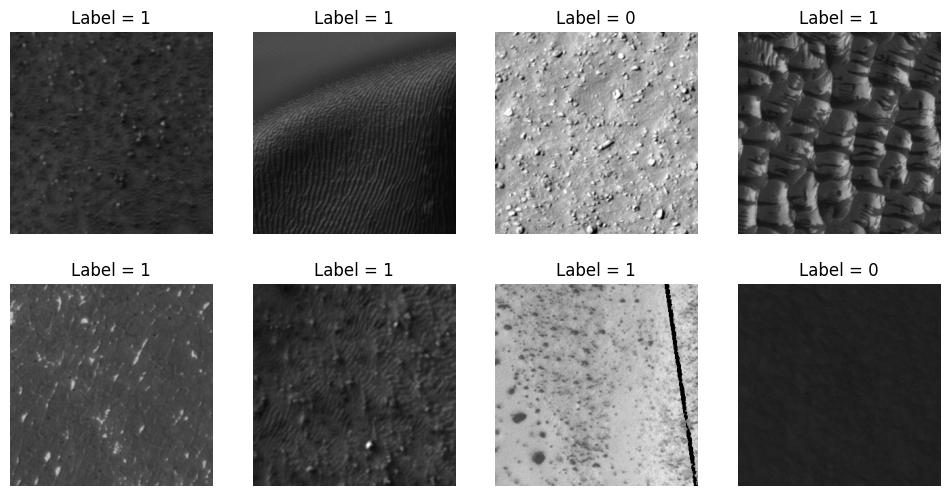

In [7]:
# Explore random images from training set as example
plt.figure(figsize=(12, 6))
for images, labels in tf_dataset_train.take(1):
  for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title('Label = ' + str(labels[i].numpy()))
    plt.axis("off")

#### 1. (c) Training CNN + MLP

##### 1. (c) i. Image Augmentation
To perform empirical regularization, crop, randomly zoom, rotate, flip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV.

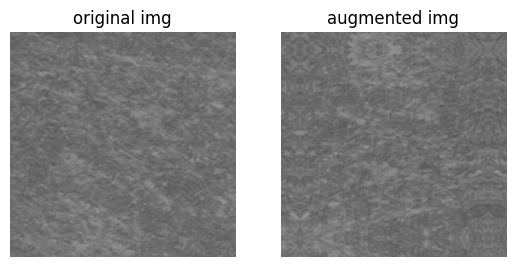

In [8]:
# Set up an augmentation model
augmentation_model = tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal_and_vertical'),
                                          tf.keras.layers.RandomRotation(0.25),
                                          tf.keras.layers.RandomZoom(0.25),
                                          tf.keras.layers.RandomCrop(IMAGE_SIZE[0], IMAGE_SIZE[1]),
                                          tf.keras.layers.RandomContrast(0.25),
                                          tf.keras.layers.Resizing(IMAGE_SIZE[0], IMAGE_SIZE[1])])

# Pick a random image to apply augmentation
for image, label in tf_dataset_train.take(1):
    before = image[0]
    after = augmentation_model(before)
    break

# See if the augmentation is acceptable
plt.subplot(1, 2, 1) 
plt.imshow(before.numpy().astype('uint8'))
plt.title('original img')
plt.axis("off")

plt.subplot(1, 2, 2) 
plt.imshow(after.numpy().astype('uint8'))
plt.title('augmented img')
plt.axis("off")

plt.show() #looks good enough

In [9]:
# I will create a second training set just from randomly transformed images from the training set:

# Modify the load_and_preprocess function to include augmentation
def load_and_preprocess_and_augment(img_loc, label):
    def _inner_function(img_loc, label):
        label = int(label)   # 1=frost, 0=background
        img_loc = img_loc.numpy().decode('utf-8')
        img = Image.open(img_loc).convert('RGB')  # img in rbg

        # Apply Augmentation 
        img = tf.cast(img, tf.float32)
        img = augmentation_model(img) # random flip, rotation, zoom

        return img, label
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    return X, y

In [10]:
# Augmented Set (from training)
tf_dataset_augmented = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(train_img_list), tf.convert_to_tensor(train_label_array)))
tf_dataset_augmented = tf_dataset_augmented.map(load_and_preprocess_and_augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_augmented = tf_dataset_augmented.shuffle(buffer_size=buffer_size).batch(batch_size, drop_remainder = True) 

In [11]:
# Add the augmented datapoints to the training
tf_dataset_train_aug = tf_dataset_train.concatenate(tf_dataset_augmented)

for x, y in tf_dataset_train_aug.take(1):
    print("Batch Shape:", x.shape, y.shape)

Batch Shape: (32, 299, 299, 3) (32,)


##### 1. (c) ii. 
Train a three-layer CNN followed by a dense layer on the data. 

Choose the size of the kernels and depth of the layers and the number of neurons in the dense layer (MLP) on your own. 

Use ReLU’s in all of the layers. 

Use the softmax function, batch normalization, and a dropout rate of 30%, L2 regularization, as well as ADAM optimizer. 

Use cross entropy loss. 

Train for at least 20 epochs and perform early stopping using the validation set. Keep the network parameters that have the lowest validation error. 

Plot the training and validation errors vs. epochs.

In [14]:
# Setup the parameters
kernel_size = (4, 4) # captures locality and computationally efficient, should be okay
depth = 32 # randomly chosen for init layer, will double it on each layer
dense_units = 128 # randomly chosen for init model
dropout_rate = 0.3 
l2_param = 0.001 #  randomly chosen for init model
learning_rate = 0.001 #  randomly chosen 

# Three-layer CNN model (using ReLU and batch normalization in every layer)

# input layer
model = tf.keras.models.Sequential()
# layer 1
model.add(tf.keras.layers.Conv2D(depth, kernel_size, activation = 'relu', input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3), 
                                 padding = 'same', kernel_regularizer = l2(l2_param)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))

# layer 2
model.add(tf.keras.layers.Conv2D(depth*2, kernel_size, activation = 'relu', padding = 'same', kernel_regularizer = l2(l2_param)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))

# layer 3
model.add(tf.keras.layers.Conv2D(depth*4, kernel_size, activation = 'relu', padding = 'same', kernel_regularizer = l2(l2_param)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))

# dense layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(dense_units, activation = 'relu', kernel_regularizer = l2(l2_param)))
model.add(tf.keras.layers.Dropout(dropout_rate))

# softmax layer
model.add(tf.keras.layers.Dense(1, activation = 'softmax'))

# Get the model
model.compile(optimizer = Adam(learning_rate = learning_rate), loss = 'binary_crossentropy', metrics = ['binary_accuracy'],
              run_eagerly = False)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 299, 299, 32)      1568      
                                                                 
 batch_normalization_3 (Bat  (None, 299, 299, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 74, 74, 64)        32832     
                                                                 
 batch_normalization_4 (Bat  (None, 74, 74, 64)        256       
 chNormalization)                                                
                                                      

Epoch 1/20
1854/1854 [==============================] - 1947s 1s/step - loss: 6.2901 - binary_accuracy: 0.5877 - val_loss: 10.3390 - val_binary_accuracy: 0.3220
Epoch 2/20
1854/1854 [==============================] - 1950s 1s/step - loss: 6.2855 - binary_accuracy: 0.5878 - val_loss: 10.3417 - val_binary_accuracy: 0.3218
Epoch 3/20
1854/1854 [==============================] - 1958s 1s/step - loss: 6.2858 - binary_accuracy: 0.5878 - val_loss: 10.3404 - val_binary_accuracy: 0.3219
Epoch 4/20
1854/1854 [==============================] - 1954s 1s/step - loss: 6.2871 - binary_accuracy: 0.5877 - val_loss: 10.3390 - val_binary_accuracy: 0.3220
Epoch 5/20
1854/1854 [==============================] - 1953s 1s/step - loss: 6.2858 - binary_accuracy: 0.5878 - val_loss: 10.3377 - val_binary_accuracy: 0.3221
Epoch 6/20
1854/1854 [==============================] - 1969s 1s/step - loss: 6.2866 - binary_accuracy: 0.5877 - val_loss: 10.3390 - val_binary_accuracy: 0.3220
Epoch 7/20
1854/1854 [============

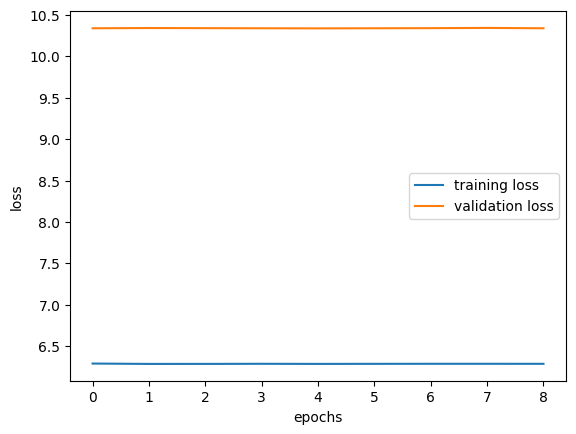

In [15]:
# Train the model
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 4, restore_best_weights = True)
tf.config.run_functions_eagerly(False)

# Train the model
model_trained = model.fit(tf_dataset_train_aug, batch_size = batch_size, epochs = 20, validation_data = tf_dataset_val, 
                        callbacks = early_stopping)

# Plot loss vs. epochs
plt.plot(model_trained.history['loss'], label = 'training loss')
plt.plot(model_trained.history['val_loss'], label = 'validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

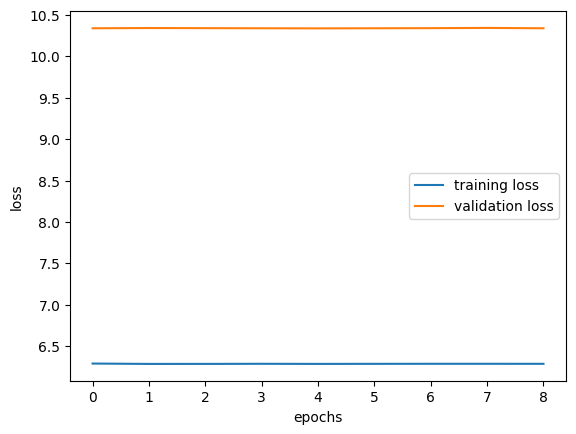

In [16]:
# Plotting here again because above output is not shown in the pdf
plt.plot(model_trained.history['loss'], label = 'training loss')
plt.plot(model_trained.history['val_loss'], label = 'validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# # Epoch loop used for dimension debugging
# num_epochs = 20 
# for epoch in range(num_epochs):
#    for batch_images, batch_labels in tf_dataset_train_aug: 
#        loss = model.train_on_batch(batch_images, batch_labels)
#    val_loss, val_accuracy = model.evaluate(tf_dataset_val)
#    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

##### 1. (c) iii. Report precision, recall, and F1 score of your model.

In [35]:
# Perform the prediction on the test set
predict_probs = model.predict(tf_dataset_test)
predicted_labels = [1 if prob > 0.5 else 0 for prob in predict_probs]

400/400 [==============================] - 108s 270ms/step


In [36]:
# Print metrics
report = classification_report(test_label_array[:len(predicted_labels)], predicted_labels) # last 15 elements are dropped for equal batch sizes
print(report)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4410
           1       0.66      1.00      0.79      8390

    accuracy                           0.66     12800
   macro avg       0.33      0.50      0.40     12800
weighted avg       0.43      0.66      0.52     12800



##### Discussion: 
Metrics table shows that all the decisions in the model are made towards class 1 which is "frost." This is the reason for classifying as "background" has zero recall and F1 score, while classifying as "frost" has 1 recall. Our model outputs class "frost" for all the data we throw at it. F1 score of 0.79 is not bad, our model's performance in classifying "frost" class images is good. However, accuracy of 0.66 is pretty low. Our model's performance can be increased by chosing different preprocessing methods (various augmentations) or different layering (no free lunch!). The flat lines in the epoch plot shows that our model did not improve in the iterations at all. We can assume a deeper network with better learning rate could result a better accuracy model, however, given the time constraint of the project, 66% accurate prediction is good enough to sell the model (better than fifty fifty!).

#### 1. (d) Transfer Learning

##### 1. (d) i. 
When dealing with classification of relatively small image datasets, deep networks may not perform very well because of not having enough data to train them. In such cases, one usually uses transfer learning, which uses deep learning models that are trained on very large datasets such as ImageNet as feature extractors. The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those features can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement layers. 

In this project, you will use pre-trained models (EfficientNetB0, ResNet50, and VGG16). For these pre-trained networks, you will only train the last fully connected layer, and will freeze all layers before them (i.e. we do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image.

##### 1. (d) ii. 
To perform empirical regularization, crop, randomly zoom, rotate, flip, con- trast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV.

In [37]:
# We have already created an augmented dataset, and merged with the training set.
# Here, I will change the augmentation model a little bit, and only perform rotations and flips.

# Set up an augmentation model
augmentation_model_2 = tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal_and_vertical'),
                                          tf.keras.layers.RandomRotation(0.25),
                                          tf.keras.layers.Resizing(IMAGE_SIZE[0], IMAGE_SIZE[1])])


# Create one more function to include augmentation
def load_and_preprocess_and_augment_2(img_loc, label):
    def _inner_function(img_loc, label):
        label = int(label)   # 1=frost, 0=background
        img_loc = img_loc.numpy().decode('utf-8')
        img = Image.open(img_loc).convert('RGB')  # img in rbg

        # Apply Augmentation 
        img = tf.cast(img, tf.float32)
        img = augmentation_model_2(img) # no zoom

        return img, label
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    return X, y

# Create the new augmented set
tf_dataset_augmented_2 = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(train_img_list), tf.convert_to_tensor(train_label_array)))
tf_dataset_augmented_2 = tf_dataset_augmented_2.map(load_and_preprocess_and_augment_2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_augmented_2 = tf_dataset_augmented_2.shuffle(buffer_size=buffer_size)
tf_dataset_augmented_2 = tf_dataset_augmented_2.batch(batch_size, drop_remainder = True)

# Merge the training
tf_dataset_train_aug_2 = tf_dataset_train.concatenate(tf_dataset_augmented_2)

for x, y in tf_dataset_train_aug_2.take(1):
    print("Batch Shape:", x.shape, y.shape)

Batch Shape: (32, 299, 299, 3) (32,)


##### 1. (d) iii. 
Use ReLU activation functions in the last layer and a softmax layer, along with batch normalization 5 and a dropout rate of 30% as well as ADAM optimizer. Use cross entropy loss. You can try any batch size, but a batch size of 8 seems reasonable.

In [ ]:
# Load and preprocess your dataset (replace with your actual code)
# ...

# Load pre-trained models (EfficientNetB0, ResNet50, VGG16) without top layers
efficientnet_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(YOUR_IMAGE_SIZE))
resnet_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(YOUR_IMAGE_SIZE))
vgg16_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(YOUR_IMAGE_SIZE))

# Extract features using pre-trained models
efficientnet_features = efficientnet_model.predict(YOUR_IMAGES)
resnet_features = resnet_model.predict(YOUR_IMAGES)
vgg16_features = vgg16_model.predict(YOUR_IMAGES)

# Concatenate the features from the three models
concatenated_features = tf.keras.layers.Concatenate()([efficientnet_features, resnet_features, vgg16_features])

# Build a simple classification model on top of the concatenated features
model = Sequential([
    Dense(128, activation='relu', input_shape=(concatenated_features.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')  # Adjust NUM_CLASSES based on your classification task
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    concatenated_features,  # Use the concatenated features as input
    YOUR_LABELS,  # Replace with your actual labels
    epochs=20,  # Preferably 20 epochs
    validation_split=0.2,  # Adjust validation split based on your preference
    callbacks=[early_stopping]
)

# Plot training and validation errors
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##### 1. (d) iv. 
Train using the features calculated by networks (EfficientNetB0, ResNet50, and VGG16) for at least 10 epochs (preferably 20 epochs) and perform early stopping using the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.

##### 1. (d) v. 
Report Precision, Recall, and F1 score for your model.

In [22]:
# Testing Set
tf_dataset_test = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(test_img_list), tf.convert_to_tensor(test_label_array)))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size = buffer_size)
tf_dataset_test = tf_dataset_test.batch(batch_size,  drop_remainder = True) 

##### 1. (d) vi. 
Compare the results of transfer learning with those of CNN + MLP model and explain them.
